In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

plt.style.use("ggplot")

print(tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

True
Num GPUs Available:  1


In [15]:
RECORDS_PATH = "../data/records"
TRAIN_FILENAMES = tf.io.gfile.glob(RECORDS_PATH + "/train/train_*.tfrecord")
VAL_FILENAMES = tf.io.gfile.glob(RECORDS_PATH + "/val/val_*.tfrecord")
VISUAL_FILENAMES = ["../data/records/visual.tfrecord"]

print(f"Number of training files: {len(TRAIN_FILENAMES)}")
print(f"Number of validation files: {len(VAL_FILENAMES)}")

Number of training files: 101
Number of validation files: 13


In [3]:
EMBEDDING_DIM = 16
JUDGMENT_DIM = 4
BEATMAP_CONTEXT_DIM = 8

FEATURE_DESCRIPTION = {
    "embeddings": tf.io.VarLenFeature(dtype = tf.float32),
    "judgments": tf.io.VarLenFeature(dtype = tf.int64),
    "beatmap_context": tf.io.FixedLenFeature([8], dtype = tf.float32),
    "replay_length": tf.io.FixedLenFeature([], dtype = tf.int64),
}

### Build TF Dataset Loader

In [4]:
NOTES_PER_EXAMPLE = 8
NOTES_PER_REPLAY = 256

def reformat_example(example):

    feature_tensor_slices = []
    label_tensor_slices = []

    replay_len = example["replay_length"]
    embeddings = tf.reshape( example["embeddings"].values, [replay_len, EMBEDDING_DIM])
    judgments  = tf.reshape( example["judgments"].values, [replay_len, JUDGMENT_DIM])
    beatmap_context = tf.reshape( example["beatmap_context"], [1, BEATMAP_CONTEXT_DIM ] )
     
    for note_idx in range(NOTES_PER_REPLAY):
        feature_tensor_slices.append(
            tf.concat([
                beatmap_context, 
                tf.reshape(embeddings[replay_len - note_idx - NOTES_PER_EXAMPLE : replay_len - note_idx , :], [1, NOTES_PER_EXAMPLE * EMBEDDING_DIM])
            ], axis = 1)
        )
        label_tensor_slices.append(
            tf.reshape(judgments[replay_len - note_idx - 1, :], [1, JUDGMENT_DIM])
        )
    
    feature_tensor = tf.concat(feature_tensor_slices, axis = 0)
    label_tensor = tf.concat(label_tensor_slices, axis = 0)
    
    feature_dataset = tf.data.Dataset.from_tensor_slices(feature_tensor)
    label_dataset = tf.data.Dataset.from_tensor_slices(label_tensor)
    
    return tf.data.Dataset.zip((feature_dataset, label_dataset))


def filter_example_len(example):
    return tf.greater_equal(example["replay_length"], NOTES_PER_EXAMPLE + NOTES_PER_REPLAY)
         

def parse_example(raw_data):
    example_obj = tf.io.parse_single_example(raw_data, FEATURE_DESCRIPTION)
    return example_obj


In [5]:
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 4096

def load_dataset(filenames):

    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed

    dataset = tf.data.TFRecordDataset(
        filenames,
        compression_type = "ZLIB"
    ) 

    dataset = dataset.with_options(
        ignore_order
    ) 

    dataset = dataset.map(
        parse_example, num_parallel_calls = tf.data.AUTOTUNE
    )

    return dataset


def get_dataset(filenames):

    dataset = load_dataset(filenames)
    dataset = dataset.filter(filter_example_len)
    dataset = dataset.flat_map(reformat_example)
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration = True)
    dataset = dataset.prefetch(buffer_size = tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

### Do Grid Search

In [29]:
def build_naive_model(num_hidden_layers, hidden_layer_size, pct_dropout):
    
    inputs = tf.keras.layers.Input(shape = [NOTES_PER_EXAMPLE * EMBEDDING_DIM + BEATMAP_CONTEXT_DIM,])
    
    x = tf.keras.layers.Dense(hidden_layer_size, activation = "relu", name = "hidden_0")(inputs)
    x = tf.keras.layers.Dropout(pct_dropout, name = "dropout_0")(x)

    for i in range(1, num_hidden_layers):
        x = tf.keras.layers.Dense(hidden_layer_size, activation = "relu", name = f"hidden_{i}")(x)
        x = tf.keras.layers.Dropout(pct_dropout, name = f"dropout_{i}")(x)

    outputs = tf.keras.layers.Dense(JUDGMENT_DIM, activation = "softmax", name = "output_layer")(x)

    model = tf.keras.Model(inputs = inputs, outputs = outputs, name = f"{num_hidden_layers}_{hidden_layer_size}_{pct_dropout}")

    return model


def get_lr_schedule(init_learning_rate, decay_step_count):
    return tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = init_learning_rate, decay_steps = decay_step_count, decay_rate = 0.96, staircase = True
    )
    
def get_optimizer(idx):
    if idx == 0:
        return tf.keras.optimizers.Adam()
    if idx == 1:
        return tf.keras.optimizers.Adam(learning_rate = get_lr_schedule(0.001, 1000))
    if idx == 2:
        return tf.keras.optimizers.Adam(clipnorm = 1, learning_rate = get_lr_schedule(0.001, 1000))
    

In [30]:
hidden_layer_counts = [5, 6, 7]
hidden_layer_sizes = [512, 1024]
num_optimizers = 3

NUM_EPOCHS = 1

histories = []

for layer_count in hidden_layer_counts:
    for layer_size in hidden_layer_sizes:
        for o_idx in range(num_optimizers):
                
            print(f"\n\nTraining model {(layer_count, layer_size, o_idx)}\n")
            
            model = build_naive_model(
                num_hidden_layers = layer_count,
                hidden_layer_size = layer_size,
                pct_dropout = 0   
            )
            
            opt = get_optimizer(o_idx)
            
            model.compile(
                optimizer = opt,
                loss = "categorical_crossentropy",
                metrics = [
                    tf.keras.metrics.CategoricalAccuracy(name = "categorical_acc")
                ]
            )
            
            train_dataset = get_dataset(TRAIN_FILENAMES)
            val_dataset = get_dataset(VAL_FILENAMES)
            
            history = model.fit(
                
                train_dataset,
                epochs = NUM_EPOCHS,
                validation_data = val_dataset,
                
            )
            
            model.save(f"naive_{layer_count}_{layer_size}_{o_idx}.keras")
            
            histories.append([
                layer_count, layer_size, o_idx, 
                history.history["loss"], history.history["categorical_acc"], 
                history.history["val_loss"], history.history["val_categorical_acc"]
            ])



Training model (5, 512, 0)

177291/177291 [==============================] - 1131s 6ms/step - loss: 0.3343 - categorical_acc: 0.9065 - val_loss: 0.3347 - val_categorical_acc: 0.9065


Training model (5, 512, 1)

177291/177291 [==============================] - 1139s 6ms/step - loss: 0.3321 - categorical_acc: 0.9065 - val_loss: 0.3291 - val_categorical_acc: 0.9065


Training model (5, 512, 2)

177291/177291 [==============================] - 1793s 10ms/step - loss: 0.3315 - categorical_acc: 0.9065 - val_loss: 0.3296 - val_categorical_acc: 0.9065


Training model (5, 1024, 0)

177291/177291 [==============================] - 1170s 7ms/step - loss: 0.3348 - categorical_acc: 0.9065 - val_loss: 0.3366 - val_categorical_acc: 0.9065


Training model (5, 1024, 1)

177291/177291 [==============================] - 1207s 7ms/step - loss: 0.3347 - categorical_acc: 0.9065 - val_loss: 0.3294 - val_categorical_acc: 0.9065


Training model (5, 1024, 2)

177291/177291 [==============================]

### Train Final Model

In [35]:
FINAL_NUM_LAYERS = 5
FINAL_LAYER_SIZE = 512
FINAL_OPT_IDX = 1
FINAL_NUM_EPOCHS = 3

model = build_naive_model(
    num_hidden_layers = FINAL_NUM_LAYERS,
    hidden_layer_size = FINAL_LAYER_SIZE,
    pct_dropout = 0   
)

opt = get_optimizer(o_idx)

model.compile(
    optimizer = opt,
    loss = "categorical_crossentropy",
    metrics = [
        tf.keras.metrics.CategoricalAccuracy(name = "categorical_acc")
    ]
)

train_dataset = get_dataset(TRAIN_FILENAMES)
val_dataset = get_dataset(VAL_FILENAMES)

history = model.fit(
    
    train_dataset,
    epochs = FINAL_NUM_EPOCHS,
    validation_data = val_dataset,
    
)

Epoch 1/3
177291/177291 [==============================] - 1952s 11ms/step - loss: 0.3317 - categorical_acc: 0.9065 - val_loss: 0.3293 - val_categorical_acc: 0.9065
Epoch 2/3
177291/177291 [==============================] - 1894s 11ms/step - loss: 0.3292 - categorical_acc: 0.9065 - val_loss: 0.3293 - val_categorical_acc: 0.9065
Epoch 3/3
177291/177291 [==============================] - 1910s 11ms/step - loss: 0.3292 - categorical_acc: 0.9065 - val_loss: 0.3293 - val_categorical_acc: 0.9065


In [36]:
# model.save(f"naive_final.keras")

### Visualize Performance

In [37]:
MODEL_PATH = "../models/naive/naive_final.keras"
model = tf.keras.models.load_model(MODEL_PATH)

In [41]:
BATCH_SIZE = 1024

context_labels = [
    "ar",
    "circle_radius",
    "hp",
    "hitwindow_300",
    "hitwindow_100",
    "hitwindow_50",
    "hd",
    "dt",
]

emb_labels = [
    "x_pos",
    "y_pos",
    "in_x_offset",
    "in_y_offset",
    "in_dist",
    "in_timedelta",
    "out_x_offset",
    "out_y_offset",
    "out_dist",
    "out_timedelta",
    "angle",
    "is_slider",
    "slider_duration",
    "slider_length",
    "slider_num_ticks",
    "slider_num_beats"
]

true_labels = [
    "300",
    "100",
    "50",
    "miss"
]

prob_labels = [
    "p_300",
    "p_100",
    "p_50",
    "p_miss"
]

val_dataset = get_dataset(VAL_FILENAMES)
features, labels = next(iter(val_dataset))
probs = model.predict_on_batch(features)

notes_df = pd.DataFrame(
    np.concatenate(
        (features[:, :BEATMAP_CONTEXT_DIM], features[:, -EMBEDDING_DIM:], labels, probs), 
        axis = 1
    ), columns = context_labels + emb_labels + true_labels + prob_labels
)

print(len(notes_df))
notes_df.head()

1024


,ar,circle_radius,hp,hitwindow_300,hitwindow_100,hitwindow_50,hd,dt,x_pos,y_pos,...,slider_num_ticks,slider_num_beats,300,100,50,miss,p_300,p_100,p_50,p_miss
0,500.0,36.480000,8.0,21.333334,50.666668,80.000000,0.0,1.0,192.0,112.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.936998,5.573041e-02,1.825591e-03,0.005446
1,400.0,37.375999,5.4,18.133333,46.400002,74.666664,1.0,1.0,464.0,200.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.915242,4.091365e-02,7.432893e-04,0.043101
2,400.0,36.480000,6.0,21.333334,50.666668,80.000000,0.0,1.0,414.0,263.0,...,2.0,0.5,1.0,0.0,0.0,0.0,0.921000,5.621882e-09,8.616827e-11,0.078999
3,400.0,36.480000,6.0,21.333334,50.666668,80.000000,0.0,1.0,284.0,20.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.774019,7.680413e-02,3.888884e-03,0.145288
4,600.0,36.480000,7.0,32.000000,76.000000,120.000000,0.0,0.0,224.0,64.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.866600,9.248181e-02,7.054115e-03,0.033864


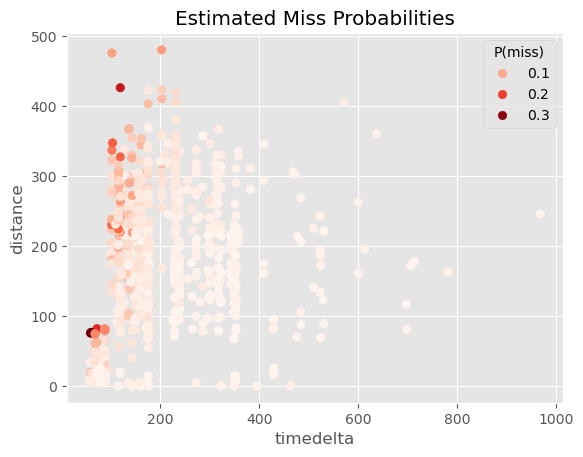

In [48]:
fig, ax = plt.subplots()

plt.title("Estimated Miss Probabilities")

scatter = ax.scatter("in_timedelta", "in_dist", c = "p_miss", cmap = "Reds", data = notes_df)
ax.set_xlabel("timedelta")
ax.set_ylabel("distance")

legend1 = ax.legend(*scatter.legend_elements(num = 4), title = "P(miss)")
